# CP3 - Leukemia Feature Selection 
# Corpataux Sam, Koch Gaël

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from functools import reduce
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Import the data

In [2]:
# read the data into a dataframe --> there is not the class
df_x = pd.read_csv('https://drive.switch.ch/index.php/s/mBWgEscKK1wpHJJ/download?path=%2F&files=GSE13204-GPL570_series_matrix.txt.gz', sep='\t', header=65)
df_x = pd.DataFrame.transpose(df_x)
new_header = df_x.iloc[0] 
df_x = df_x[1:] 
df_x.columns = new_header 
df_x = df_x.dropna(axis=1,how='all')
df_x.head()

ID_REF,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMRGE/M10098_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,AFFX-M27830_3_at,AFFX-M27830_5_at,AFFX-M27830_M_at
GSM329407,0.361346,0.450274,0.431178,0.405517,0.160812,0.568845,0.236371,0.020181,0.793796,0.101112,...,0.718074,0.433772,0.516903,0.480186,0.416394,0.480112,0.474266,0.196546,0.455276,0.607962
GSM329408,0.396426,0.559457,0.402577,0.437968,0.08913,0.526262,0.370959,0.118863,0.411771,0.231975,...,0.578789,0.305685,0.389508,0.370612,0.567414,0.588449,0.575516,0.296013,0.499546,0.570179
GSM329409,0.419317,0.436466,0.306609,0.479352,0.117863,0.532214,0.348458,0.095052,0.621742,0.249171,...,0.47976,0.221501,0.248076,0.277969,0.480558,0.498713,0.522232,0.157139,0.542367,0.655399
GSM329410,0.424651,0.512677,0.217119,0.484471,0.222672,0.452757,0.393106,0.337601,0.481378,0.078431,...,0.534108,0.182823,0.355785,0.196156,0.270626,0.520508,0.414519,0.186461,0.468462,0.650308
GSM329411,0.287776,0.194097,0.355157,0.453368,0.180248,0.571522,0.188911,0.217023,0.772696,0.27619,...,0.65905,0.047018,0.224651,0.354375,0.32994,0.404139,0.184868,0.136972,0.24414,0.637725


In [3]:
# read the classes of the samples
df_y = pd.read_csv('https://drive.switch.ch/index.php/s/mBWgEscKK1wpHJJ/download?path=%2F&files=GSE13204-GPL570_series_matrix.txt.gz', sep='\t', header=None, nrows=1, skiprows=np.arange(0, 40))
df_y = pd.DataFrame.transpose(df_y)
new_header = df_y.iloc[0] 
df_y = df_y[1:] 
df_y.columns = new_header 
df_y = df_y.dropna(axis=1,how='all')
df_y.head()

,!Sample_characteristics_ch1
1,leukemia class: mature B-ALL with t(8;14)
2,leukemia class: mature B-ALL with t(8;14)
3,leukemia class: mature B-ALL with t(8;14)
4,leukemia class: mature B-ALL with t(8;14)
5,leukemia class: mature B-ALL with t(8;14)


# Quick data analysis

In [4]:
# define names
x_labels = df_x.columns
y_labels = df_y.columns
print(x_labels)
print(y_labels)

Index(['1007_s_at', '1053_at', '117_at', '121_at', '1255_g_at', '1294_at',
       '1316_at', '1320_at', '1405_i_at', '1431_at',
       ...
       'AFFX-HUMISGF3A/M97935_3_at', 'AFFX-HUMISGF3A/M97935_5_at',
       'AFFX-HUMISGF3A/M97935_MA_at', 'AFFX-HUMISGF3A/M97935_MB_at',
       'AFFX-HUMRGE/M10098_3_at', 'AFFX-HUMRGE/M10098_5_at',
       'AFFX-HUMRGE/M10098_M_at', 'AFFX-M27830_3_at', 'AFFX-M27830_5_at',
       'AFFX-M27830_M_at'],
      dtype='object', name='ID_REF', length=54630)
Index(['!Sample_characteristics_ch1'], dtype='object', name=0)


In [5]:
# for features
# check the shape
print('Nb samples = '+str(df_x.shape[0]) + ', nb features = ' + str(df_x.shape[1]))
# check if there are nan values
count_nan = df_x.isna().sum().sum()
print(count_nan)

Nb samples = 2096, nb features = 54630
0


In [6]:
# for classes
# check the shape
print('Nb samples = '+str(df_y.shape[0]) + ', nb features = ' + str(df_y.shape[1]))
# check if there are nan values
count_nan = df_y.isna().sum().sum()
print(count_nan)

Nb samples = 2096, nb features = 1
0


In [7]:
# check number of samples per classes --> also get the number of classes
def print_classes_occur(data):
    classes, occurences = np.unique(data.values, return_counts=True)
    print('Nb classes: ', len(classes))
    for i in range(0, len(classes)):
        print(classes[i] + ': ' + str(occurences[i]))
    print('Total: '+ str(np.sum(occurences)))
print_classes_occur(df_y)

Nb classes:  18
leukemia class: ALL with hyperdiploid karyotype: 40
leukemia class: ALL with t(12;21): 58
leukemia class: ALL with t(1;19): 36
leukemia class: AML complex aberrant karyotype: 48
leukemia class: AML with inv(16)/t(16;16): 28
leukemia class: AML with normal karyotype + other abnormalities: 351
leukemia class: AML with t(11q23)/MLL: 38
leukemia class: AML with t(15;17): 37
leukemia class: AML with t(8;21): 40
leukemia class: CLL: 448
leukemia class: CML: 76
leukemia class: MDS: 206
leukemia class: Non-leukemia and healthy bone marrow: 74
leukemia class: Pro-B-ALL with t(11q23)/MLL: 70
leukemia class: T-ALL: 174
leukemia class: c-ALL/Pre-B-ALL with t(9;22): 122
leukemia class: c-ALL/Pre-B-ALL without t(9;22): 237
leukemia class: mature B-ALL with t(8;14): 13
Total: 2096


# Dataset creation with different classes groups

The features dataset doesn't need manipulation. Only the classification is changing here

In [8]:
# dataset with all the classes
df_y1 = df_y.copy()
print_classes_occur(df_y1)

le1 = preprocessing.LabelEncoder()
le1.fit(df_y1)

Nb classes:  18
leukemia class: ALL with hyperdiploid karyotype: 40
leukemia class: ALL with t(12;21): 58
leukemia class: ALL with t(1;19): 36
leukemia class: AML complex aberrant karyotype: 48
leukemia class: AML with inv(16)/t(16;16): 28
leukemia class: AML with normal karyotype + other abnormalities: 351
leukemia class: AML with t(11q23)/MLL: 38
leukemia class: AML with t(15;17): 37
leukemia class: AML with t(8;21): 40
leukemia class: CLL: 448
leukemia class: CML: 76
leukemia class: MDS: 206
leukemia class: Non-leukemia and healthy bone marrow: 74
leukemia class: Pro-B-ALL with t(11q23)/MLL: 70
leukemia class: T-ALL: 174
leukemia class: c-ALL/Pre-B-ALL with t(9;22): 122
leukemia class: c-ALL/Pre-B-ALL without t(9;22): 237
leukemia class: mature B-ALL with t(8;14): 13
Total: 2096


c:\Users\gakoo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LabelEncoder()

In [9]:
# dataset with 5 big classes --> ALL, AML, CLL, CML, and OTHERS
df_y2 = df_y.copy()
df_y2.loc[df_y2[y_labels.values[0]] == 'leukemia class: ALL with hyperdiploid karyotype'] = 'ALL'
df_y2.loc[df_y2[y_labels.values[0]] == 'leukemia class: ALL with t(12;21)'] = 'ALL'
df_y2.loc[df_y2[y_labels.values[0]] == 'leukemia class: ALL with t(1;19)'] = 'ALL'
df_y2.loc[df_y2[y_labels.values[0]] == 'leukemia class: AML complex aberrant karyotype'] = 'AML'
df_y2.loc[df_y2[y_labels.values[0]] == 'leukemia class: AML with inv(16)/t(16;16)'] = 'AML'
df_y2.loc[df_y2[y_labels.values[0]] == 'leukemia class: AML with normal karyotype + other abnormalities'] = 'AML'
df_y2.loc[df_y2[y_labels.values[0]] == 'leukemia class: AML with t(11q23)/MLL'] = 'AML'
df_y2.loc[df_y2[y_labels.values[0]] == 'leukemia class: AML with t(15;17)'] = 'AML'
df_y2.loc[df_y2[y_labels.values[0]] == 'leukemia class: AML with t(8;21)'] = 'AML'
df_y2.loc[df_y2[y_labels.values[0]] == 'leukemia class: CLL'] = 'CLL'
df_y2.loc[df_y2[y_labels.values[0]] == 'leukemia class: CML'] = 'CML'
df_y2.loc[df_y2[y_labels.values[0]] == 'leukemia class: MDS'] = 'OTHERS'
df_y2.loc[df_y2[y_labels.values[0]] == 'leukemia class: Non-leukemia and healthy bone marrow'] = 'OTHERS'
df_y2.loc[df_y2[y_labels.values[0]] == 'leukemia class: Pro-B-ALL with t(11q23)/MLL'] = 'ALL'
df_y2.loc[df_y2[y_labels.values[0]] == 'leukemia class: T-ALL'] = 'ALL'
df_y2.loc[df_y2[y_labels.values[0]] == 'leukemia class: c-ALL/Pre-B-ALL with t(9;22)'] = 'ALL'
df_y2.loc[df_y2[y_labels.values[0]] == 'leukemia class: c-ALL/Pre-B-ALL without t(9;22)'] = 'ALL'
df_y2.loc[df_y2[y_labels.values[0]] == 'leukemia class: mature B-ALL with t(8;14)'] = 'ALL'
print_classes_occur(df_y2)
le2 = preprocessing.LabelEncoder()
le2.fit(df_y2)

Nb classes:  5
ALL: 750
AML: 542
CLL: 448
CML: 76
OTHERS: 280
Total: 2096


LabelEncoder()

In [10]:
# dataset with positive and negative --> most frequent class is CLL
df_y3 = df_y.copy()
df_y3.loc[df_y3[y_labels.values[0]] == 'leukemia class: ALL with hyperdiploid karyotype'] = 'NEGATIVE'
df_y3.loc[df_y3[y_labels.values[0]] == 'leukemia class: ALL with t(12;21)'] = 'NEGATIVE'
df_y3.loc[df_y3[y_labels.values[0]] == 'leukemia class: ALL with t(1;19)'] = 'NEGATIVE'
df_y3.loc[df_y3[y_labels.values[0]] == 'leukemia class: AML complex aberrant karyotype'] = 'NEGATIVE'
df_y3.loc[df_y3[y_labels.values[0]] == 'leukemia class: AML with inv(16)/t(16;16)'] = 'NEGATIVE'
df_y3.loc[df_y3[y_labels.values[0]] == 'leukemia class: AML with normal karyotype + other abnormalities'] = 'NEGATIVE'
df_y3.loc[df_y3[y_labels.values[0]] == 'leukemia class: AML with t(11q23)/MLL'] = 'NEGATIVE'
df_y3.loc[df_y3[y_labels.values[0]] == 'leukemia class: AML with t(15;17)'] = 'NEGATIVE'
df_y3.loc[df_y3[y_labels.values[0]] == 'leukemia class: AML with t(8;21)'] = 'NEGATIVE'
df_y3.loc[df_y3[y_labels.values[0]] == 'leukemia class: CLL'] = 'POSITIVE'
df_y3.loc[df_y3[y_labels.values[0]] == 'leukemia class: CML'] = 'NEGATIVE'
df_y3.loc[df_y3[y_labels.values[0]] == 'leukemia class: MDS'] = 'NEGATIVE'
df_y3.loc[df_y3[y_labels.values[0]] == 'leukemia class: Non-leukemia and healthy bone marrow'] = 'NEGATIVE'
df_y3.loc[df_y3[y_labels.values[0]] == 'leukemia class: Pro-B-ALL with t(11q23)/MLL'] = 'NEGATIVE'
df_y3.loc[df_y3[y_labels.values[0]] == 'leukemia class: T-ALL'] = 'NEGATIVE'
df_y3.loc[df_y3[y_labels.values[0]] == 'leukemia class: c-ALL/Pre-B-ALL with t(9;22)'] = 'NEGATIVE'
df_y3.loc[df_y3[y_labels.values[0]] == 'leukemia class: c-ALL/Pre-B-ALL without t(9;22)'] = 'NEGATIVE'
df_y3.loc[df_y3[y_labels.values[0]] == 'leukemia class: mature B-ALL with t(8;14)'] = 'NEGATIVE'
print_classes_occur(df_y3)
le3 = preprocessing.LabelEncoder()
le3.fit(df_y3)

Nb classes:  2
NEGATIVE: 1648
POSITIVE: 448
Total: 2096


LabelEncoder()

In [11]:
# split all the dataset into training and testing 
all_X_train = []
all_y_train = []
X_train1, X_test1, y_train1, y_test1 = train_test_split(df_x, df_y1, test_size=0.3, random_state=42)
all_X_train.append(X_train1)
all_y_train.append(y_train1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_x, df_y2, test_size=0.3, random_state=42)
all_X_train.append(X_train2)
all_y_train.append(y_train2)
X_train3, X_test3, y_train3, y_test3 = train_test_split(df_x, df_y3, test_size=0.3, random_state=42)
all_X_train.append(X_train3)
all_y_train.append(y_train3)

# Feature selection 1 : filter-based methods (5k to 10k)

In [12]:
# returns the name of the N features with the best scores
def anova_filter(X_train, y_train, nb_features, features):
    fs = SelectKBest(score_func=f_classif, k='all')
    fs.fit(X_train, y_train.values.ravel())
    # sort the best features
    order = fs.scores_.argsort()
    sorted_features = np.array(features)[order[::-1]]
    return sorted_features[0:nb_features]

In [13]:
def mutual_info_filter(X_train, y_train, nb_features, features):
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_train, y_train.values.ravel())
    # sort the best features
    order = fs.scores_.argsort()
    sorted_features = np.array(features)[order[::-1]]
    return sorted_features[0:nb_features]

In [14]:
def chi_filter(X_train, y_train, nb_features, features):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train.values.ravel())
    # sort the best features
    order = fs.scores_.argsort()
    sorted_features = np.array(features)[order[::-1]]
    return sorted_features[0:nb_features]

In [15]:
def test_stability(X_train, y_train, nb_features, nb_iter, func, features=x_labels.values):
    selected_features = func(X_train, y_train, nb_features, features)
    selected_features_test = []
    for i in range(0, nb_iter):
        selected_features_test.append(func(X_train, y_train, nb_features, features))
    nb_false = 0
    result = selected_features_test == selected_features
    for i in range(0, len(selected_features_test)):
        if(False in result[i]):
            nb_false += 1
    print("pourcentage not same : ", str((nb_false/len(selected_features_test))*100)) # 0% is good (always same)
    return selected_features


In [16]:
# generate features
nb_test = 1
features_number = [5000, 7500, 10000]
dict_filters = dict()
filters_name = ['anova', 'chi2']

for nb in features_number:
    for i in range(0, len(all_X_train)):
        dict_filters['anova_df'+str(i+1)+'_nb'+str(nb)] = test_stability(all_X_train[i], all_y_train[i], nb, nb_test, anova_filter)
        # TODO: taking really long (136min on my machine) for results not better --> Google Colab has the same problem
        # dict_filters['mutual_df'+str(i+1)+'_nb'+str(nb)] = test_stability(all_X_train[i], all_y_train[i], nb, nb_test, mutual_info_filter) 
        dict_filters['chi2_df'+str(i+1)+'_nb'+str(nb)] = test_stability(all_X_train[i], all_y_train[i], nb, nb_test, chi_filter)

print(dict_filters)

pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
{'anova_df1_nb5000': array(['226147_s_at', '220118_at', '239287_at', ..., '209604_s_at',
       '209346_s_at', '203127_s_at'], dtype=object), 'chi2_df1_nb5000': array(['220118_at', '206760_s_at', '226147_s_at', ..., '205456_at',
       '225080_at', '239657_x_at'], dtype=object), 'anova_df2_nb5000': array(['226147_s_at', '220118_at', '239287_at', ..., '235587_at',
       '1556346_at', '244304_at'], dtype=object), 'chi2_df2_nb5000': array(['220118_at', '206760_s_at', '226147_s_at', ..., '21274

In [17]:
# check precentage of same features in the sets
def percentage_same_features(ar_features_set, title):
    all_sizes = []
    for i in range(0, len(ar_features_set)):
        all_sizes.append(len(ar_features_set[i]))
    result = reduce(np.intersect1d,(ar_features_set))
    result = (len(result)/np.max(all_sizes))*100
    print(title+' - same features: '+str(result)+'%')

In [18]:
# test different combination of features subset to see which one are similar or not

# check same features for different filters but same data with same nb features
for nb in features_number:
    for i in range(0, len(all_X_train)):
        id = 'df'+str(i+1)+'_nb'+str(nb)
        arrays = []
        for key in [k for k, v in dict_filters.items() if id in k]:
            arrays.append(dict_filters.get(key))
        percentage_same_features(arrays, id)

print('-'*50)

# check same features for same filters with same nb features
for name in filters_name:
    for nb in features_number:
        id1 = name
        id2 = 'nb'+str(nb)
        arrays = []
        for key in [k for k, v in dict_filters.items() if (id1 in k and id2 in k)]:
            arrays.append(dict_filters.get(key))
        percentage_same_features(arrays, id1+'_'+id2)

print('-'*50)

# check same features for different filters but different data
for nb in features_number:
    id = 'nb'+str(nb)
    arrays = []
    for key in [k for k, v in dict_filters.items() if id in k]:
        arrays.append(dict_filters.get(key))
    percentage_same_features(arrays, id)

df1_nb5000 - same features: 56.74%
df2_nb5000 - same features: 57.49999999999999%
df3_nb5000 - same features: 60.519999999999996%
df1_nb7500 - same features: 60.45333333333333%
df2_nb7500 - same features: 60.440000000000005%
df3_nb7500 - same features: 65.61333333333333%
df1_nb10000 - same features: 62.57%
df2_nb10000 - same features: 63.370000000000005%
df3_nb10000 - same features: 69.97%
--------------------------------------------------
anova_nb5000 - same features: 55.16%
anova_nb7500 - same features: 58.93333333333334%
anova_nb10000 - same features: 62.260000000000005%
chi2_nb5000 - same features: 63.28%
chi2_nb7500 - same features: 65.82666666666667%
chi2_nb10000 - same features: 67.03%
--------------------------------------------------
nb5000 - same features: 30.380000000000003%
nb7500 - same features: 34.93333333333333%
nb10000 - same features: 38.45%


We can take the 38% of the same features from anova_10000 and chi2_10000 ang that results us in ~3'800 features.
Those features were present in anova and chi2 feature selection for all the different dataset. We can still test the 
different other subset

In [19]:
# create the 'final' features subset from phase 1 with features in all the filters and datasets
arrays = []
for key in [k for k, v in dict_filters.items() if 'nb10000' in k]:
    arrays.append(dict_filters.get(key))
p1_subset_all = reduce(np.intersect1d,(arrays))
print('Nb features all: '+str(len(p1_subset_all)))

# create the 'final' features subset from phase 1 with features in all the datasets but filter anova
arrays = []
for key in [k for k, v in dict_filters.items() if ('anova' in k and 'nb10000' in k)]:
    arrays.append(dict_filters.get(key))
p1_subset_anova = reduce(np.intersect1d,(arrays))
print('Nb features anova: '+str(len(p1_subset_anova)))

# create the 'final' features subset from phase 1 with features in all the datasets but filter chi2
arrays = []
for key in [k for k, v in dict_filters.items() if ('chi2' in k and 'nb10000' in k)]:
    arrays.append(dict_filters.get(key))
p1_subset_chi2 = reduce(np.intersect1d,(arrays))
print('Nb features chi2: '+str(len(p1_subset_chi2)))

# create the 'final' features subset from phase 1 with features in all the filters but in dataset1
arrays = []
for key in [k for k, v in dict_filters.items() if 'df1_nb10000' in k]:
    arrays.append(dict_filters.get(key))
p1_subset_df1 = reduce(np.intersect1d,(arrays))
print('Nb features df1: '+str(len(p1_subset_df1)))

# create the 'final' features subset from phase 1 with features in all the filters but in dataset2
arrays = []
for key in [k for k, v in dict_filters.items() if 'df2_nb10000' in k]:
    arrays.append(dict_filters.get(key))
p1_subset_df2 = reduce(np.intersect1d,(arrays))
print('Nb features df2: '+str(len(p1_subset_df2)))

# create the 'final' features subset from phase 1 with features in all the filters but in dataset3
arrays = []
for key in [k for k, v in dict_filters.items() if 'df3_nb10000' in k]:
    arrays.append(dict_filters.get(key))
p1_subset_df3 = reduce(np.intersect1d,(arrays))
print('Nb features df3: '+str(len(p1_subset_df3)))

all_subset_p1 = [p1_subset_all, p1_subset_anova, p1_subset_chi2, p1_subset_df1, p1_subset_df2, p1_subset_df3]
print(len(reduce(np.intersect1d,(all_subset_p1)))) # the features in subset p1_subset_all are all present in the other subsets --> should be the case and it is here



Nb features all: 3845
Nb features anova: 6226
Nb features chi2: 6703
Nb features df1: 6257
Nb features df2: 6337
Nb features df3: 6997
3845


It would be interesting to check where those 3845 features come from --> if a subset is more restrictive than the others

# Feature selection 2 : wrapper and/or embedded methods (500 to 1000)

In [20]:
# start by removing unused features
for i in range(len(all_X_train)):
    print(all_X_train[i].shape)
    all_X_train[i] = all_X_train[i][p1_subset_all] # TODO: change p1_subset_all if you want to try different feature subset from phase 1
    print(all_X_train[i].shape)
    print('-'*50)

(1467, 54630)
(1467, 3845)
--------------------------------------------------
(1467, 54630)
(1467, 3845)
--------------------------------------------------
(1467, 54630)
(1467, 3845)
--------------------------------------------------


Now we can define our functions for wrapper / embedded methods

In [21]:
# TODO: wrapper methods takes too long --> not because of the algorithm used but because it is wrapped in RFE
def decision_tree_wrapper(X_train, y_train, nb_features, features):
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=nb_features)
    rfe.fit(X_train, y_train)
    return np.array(features)[rfe.support_]

In [22]:
def decision_tree_embedded(X_train, y_train, nb_features, features):
    dtc = DecisionTreeClassifier(random_state=42) 
    dtc.fit(X_train, y_train.values.ravel())
    # sort the best features
    order = dtc.feature_importances_.argsort()
    sorted_features = np.array(features)[order[::-1]]
    return sorted_features[0:nb_features]

In [23]:
def random_forest_embedded(X_train, y_train, nb_features, features):
    dtc = RandomForestClassifier(random_state=42) # TODO: had to put the random state to have the same features each time
    dtc.fit(X_train, y_train.values.ravel())
    # sort the best features
    order = dtc.feature_importances_.argsort()
    sorted_features = np.array(features)[order[::-1]]
    return sorted_features[0:nb_features]

In [24]:
# now we can generate all our features selection
nb_test = 1
features_number = [500, 1000, 1500]
dict_filters = dict()
filters_name = ['tree', 'forest']

for nb in features_number:
    for i in range(0, len(all_X_train)):
        dict_filters['tree_df'+str(i+1)+'_nb'+str(nb)] = test_stability(all_X_train[i], all_y_train[i], nb, nb_test, decision_tree_embedded, p1_subset_all) 
        dict_filters['forest_df'+str(i+1)+'_nb'+str(nb)] = test_stability(all_X_train[i], all_y_train[i], nb, nb_test, random_forest_embedded, p1_subset_all)

pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0


In [25]:
# test different combination of features subset to see which one are similar or not

# check same features for different filters but same data with same nb features
for nb in features_number:
    for i in range(0, len(all_X_train)):
        id = 'df'+str(i+1)+'_nb'+str(nb)
        arrays = []
        for key in [k for k, v in dict_filters.items() if id in k]:
            arrays.append(dict_filters.get(key))
        percentage_same_features(arrays, id)

print('-'*50)

# check same features for same filters with same nb features
for name in filters_name:
    for nb in features_number:
        id1 = name
        id2 = 'nb'+str(nb)
        arrays = []
        for key in [k for k, v in dict_filters.items() if (id1 in k and id2 in k)]:
            arrays.append(dict_filters.get(key))
        percentage_same_features(arrays, id1+'_'+id2)

print('-'*50)

# check same features for different filters but different data
for nb in features_number:
    id = 'nb'+str(nb)
    arrays = []
    for key in [k for k, v in dict_filters.items() if id in k]:
        arrays.append(dict_filters.get(key))
    percentage_same_features(arrays, id)

df1_nb500 - same features: 19.400000000000002%
df2_nb500 - same features: 19.8%
df3_nb500 - same features: 14.799999999999999%
df1_nb1000 - same features: 29.099999999999998%
df2_nb1000 - same features: 30.5%
df3_nb1000 - same features: 63.6%
df1_nb1500 - same features: 41.199999999999996%
df2_nb1500 - same features: 40.0%
df3_nb1500 - same features: 78.26666666666667%
--------------------------------------------------
tree_nb500 - same features: 75.2%
tree_nb1000 - same features: 89.8%
tree_nb1500 - same features: 93.4%
forest_nb500 - same features: 16.0%
forest_nb1000 - same features: 19.7%
forest_nb1500 - same features: 26.466666666666665%
--------------------------------------------------
nb500 - same features: 2.1999999999999997%
nb1000 - same features: 10.0%
nb1500 - same features: 19.133333333333333%


We could have 287 features with the comparison of all the subset of features

In [26]:
# create the 'final' features subset from phase 1 with features in all the filters and datasets
arrays = []
for key in [k for k, v in dict_filters.items() if 'nb1500' in k]:
    arrays.append(dict_filters.get(key))
p2_subset_all = reduce(np.intersect1d,(arrays))
print('Nb features all: '+str(len(p2_subset_all)))

# create the 'final' features subset from phase 1 with features in all the datasets but filter anova
arrays = []
for key in [k for k, v in dict_filters.items() if ('tree' in k and 'nb1500' in k)]:
    arrays.append(dict_filters.get(key))
p2_subset_tree = reduce(np.intersect1d,(arrays))
print('Nb features tree: '+str(len(p2_subset_tree)))

# create the 'final' features subset from phase 1 with features in all the datasets but filter chi2
arrays = []
for key in [k for k, v in dict_filters.items() if ('forest' in k and 'nb1500' in k)]:
    arrays.append(dict_filters.get(key))
p2_subset_forest = reduce(np.intersect1d,(arrays))
print('Nb features forest: '+str(len(p2_subset_forest)))

# create the 'final' features subset from phase 1 with features in all the filters but in dataset1
arrays = []
for key in [k for k, v in dict_filters.items() if 'df1_nb1500' in k]:
    arrays.append(dict_filters.get(key))
p2_subset_df1 = reduce(np.intersect1d,(arrays))
print('Nb features df1: '+str(len(p2_subset_df1)))

# create the 'final' features subset from phase 1 with features in all the filters but in dataset2
arrays = []
for key in [k for k, v in dict_filters.items() if 'df2_nb1500' in k]:
    arrays.append(dict_filters.get(key))
p2_subset_df2 = reduce(np.intersect1d,(arrays))
print('Nb features df2: '+str(len(p2_subset_df2)))

# create the 'final' features subset from phase 1 with features in all the filters but in dataset3
arrays = []
for key in [k for k, v in dict_filters.items() if 'df3_nb1500' in k]:
    arrays.append(dict_filters.get(key))
p2_subset_df3 = reduce(np.intersect1d,(arrays))
print('Nb features df3: '+str(len(p2_subset_df3)))

all_subset_p2 = [p2_subset_all, p2_subset_tree, p2_subset_forest, p2_subset_df1, p2_subset_df2, p2_subset_df3]
print(len(reduce(np.intersect1d,(all_subset_p2)))) # the features in subset p1_subset_all are all present in the other subsets --> should be the case and it is here


Nb features all: 287
Nb features tree: 1401
Nb features forest: 397
Nb features df1: 618
Nb features df2: 600
Nb features df3: 1174
287


Now let's do the same thing but this time with another subset from phase 1 --> chi2

In [27]:
all_X_train = []
all_y_train = []
X_train1, X_test1, y_train1, y_test1 = train_test_split(df_x, df_y1, test_size=0.3, random_state=42)
all_X_train.append(X_train1)
all_y_train.append(y_train1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_x, df_y2, test_size=0.3, random_state=42)
all_X_train.append(X_train2)
all_y_train.append(y_train2)
X_train3, X_test3, y_train3, y_test3 = train_test_split(df_x, df_y3, test_size=0.3, random_state=42)
all_X_train.append(X_train3)
all_y_train.append(y_train3)
for i in range(len(all_X_train)):
    print(all_X_train[i].shape)
    all_X_train[i] = all_X_train[i][p1_subset_chi2] # TODO: change p1_subset_all if you want to try different feature subset from phase 1
    print(all_X_train[i].shape)
    print('-'*50)
# now we can generate all our features selection
nb_test = 1
features_number = [500, 1000, 1500]
dict_filters = dict()
filters_name = ['tree', 'forest']

for nb in features_number:
    for i in range(0, len(all_X_train)):
        dict_filters['tree_df'+str(i+1)+'_nb'+str(nb)] = test_stability(all_X_train[i], all_y_train[i], nb, nb_test, decision_tree_embedded, p1_subset_chi2) 
        dict_filters['forest_df'+str(i+1)+'_nb'+str(nb)] = test_stability(all_X_train[i], all_y_train[i], nb, nb_test, random_forest_embedded, p1_subset_chi2)


# test different combination of features subset to see which one are similar or not

# check same features for different filters but same data with same nb features
for nb in features_number:
    for i in range(0, len(all_X_train)):
        id = 'df'+str(i+1)+'_nb'+str(nb)
        arrays = []
        for key in [k for k, v in dict_filters.items() if id in k]:
            arrays.append(dict_filters.get(key))
        percentage_same_features(arrays, id)

print('-'*50)

# check same features for same filters with same nb features
for name in filters_name:
    for nb in features_number:
        id1 = name
        id2 = 'nb'+str(nb)
        arrays = []
        for key in [k for k, v in dict_filters.items() if (id1 in k and id2 in k)]:
            arrays.append(dict_filters.get(key))
        percentage_same_features(arrays, id1+'_'+id2)

print('-'*50)

# check same features for different filters but different data
for nb in features_number:
    id = 'nb'+str(nb)
    arrays = []
    for key in [k for k, v in dict_filters.items() if id in k]:
        arrays.append(dict_filters.get(key))
    percentage_same_features(arrays, id)

arrays = []
for key in [k for k, v in dict_filters.items() if 'nb1500' in k]:
    arrays.append(dict_filters.get(key))
p2_subset_all_chi2 = reduce(np.intersect1d,(arrays))
print('Nb features all chi2: '+str(len(p2_subset_all_chi2)))

(1467, 54630)
(1467, 6703)
--------------------------------------------------
(1467, 54630)
(1467, 6703)
--------------------------------------------------
(1467, 54630)
(1467, 6703)
--------------------------------------------------
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
df1_nb500 - same features: 13.4%
df2_nb500 - same features: 13.0%
df3_nb500 - same features: 8.200000000000001%
df1_nb1000 - same features: 18.7%
df2_nb1000 - same features: 18.8%
df3_nb1000 - same features: 51.2%
df1_nb1500 - same features: 24.333333333333336%


With mores features from phase 1, we have less common feature in phase 2. So the features selected (~3800) in phase 1 were good.
We now have multiple subset of features to test with ML methods

We can do the same but with anova

In [28]:
all_X_train = []
all_y_train = []
X_train1, X_test1, y_train1, y_test1 = train_test_split(df_x, df_y1, test_size=0.3, random_state=42)
all_X_train.append(X_train1)
all_y_train.append(y_train1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_x, df_y2, test_size=0.3, random_state=42)
all_X_train.append(X_train2)
all_y_train.append(y_train2)
X_train3, X_test3, y_train3, y_test3 = train_test_split(df_x, df_y3, test_size=0.3, random_state=42)
all_X_train.append(X_train3)
all_y_train.append(y_train3)
for i in range(len(all_X_train)):
    print(all_X_train[i].shape)
    all_X_train[i] = all_X_train[i][p1_subset_anova] # TODO: change p1_subset_all if you want to try different feature subset from phase 1
    print(all_X_train[i].shape)
    print('-'*50)
# now we can generate all our features selection
nb_test = 1
features_number = [500, 1000, 1500]
dict_filters = dict()
filters_name = ['tree', 'forest']

for nb in features_number:
    for i in range(0, len(all_X_train)):
        dict_filters['tree_df'+str(i+1)+'_nb'+str(nb)] = test_stability(all_X_train[i], all_y_train[i], nb, nb_test, decision_tree_embedded, p1_subset_chi2) 
        dict_filters['forest_df'+str(i+1)+'_nb'+str(nb)] = test_stability(all_X_train[i], all_y_train[i], nb, nb_test, random_forest_embedded, p1_subset_chi2)


# test different combination of features subset to see which one are similar or not

# check same features for different filters but same data with same nb features
for nb in features_number:
    for i in range(0, len(all_X_train)):
        id = 'df'+str(i+1)+'_nb'+str(nb)
        arrays = []
        for key in [k for k, v in dict_filters.items() if id in k]:
            arrays.append(dict_filters.get(key))
        percentage_same_features(arrays, id)

print('-'*50)

# check same features for same filters with same nb features
for name in filters_name:
    for nb in features_number:
        id1 = name
        id2 = 'nb'+str(nb)
        arrays = []
        for key in [k for k, v in dict_filters.items() if (id1 in k and id2 in k)]:
            arrays.append(dict_filters.get(key))
        percentage_same_features(arrays, id1+'_'+id2)

print('-'*50)

# check same features for different filters but different data
for nb in features_number:
    id = 'nb'+str(nb)
    arrays = []
    for key in [k for k, v in dict_filters.items() if id in k]:
        arrays.append(dict_filters.get(key))
    percentage_same_features(arrays, id)

arrays = []
for key in [k for k, v in dict_filters.items() if 'nb1500' in k]:
    arrays.append(dict_filters.get(key))
p2_subset_all_anova = reduce(np.intersect1d,(arrays))
print('Nb features all anova: '+str(len(p2_subset_all_anova)))

(1467, 54630)
(1467, 6226)
--------------------------------------------------
(1467, 54630)
(1467, 6226)
--------------------------------------------------
(1467, 54630)
(1467, 6226)
--------------------------------------------------
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
pourcentage not same :  0.0
df1_nb500 - same features: 12.4%
df2_nb500 - same features: 13.8%
df3_nb500 - same features: 8.4%
df1_nb1000 - same features: 19.400000000000002%
df2_nb1000 - same features: 21.0%
df3_nb1000 - same features: 54.300000000000004%
df1_nb1500 - same features: 27.133

# Testing of ML methods with the selected features

In [29]:
all_X_train = []
all_y_train = []
X_train1, X_test1, y_train1, y_test1 = train_test_split(df_x, df_y1, test_size=0.3, random_state=42, stratify=df_y1.values)
all_X_train.append(X_train1)
all_y_train.append(y_train1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_x, df_y2, test_size=0.3, random_state=42, stratify=df_y2.values)
all_X_train.append(X_train2)
all_y_train.append(y_train2)
X_train3, X_test3, y_train3, y_test3 = train_test_split(df_x, df_y3, test_size=0.3, random_state=42, stratify=df_y3.values)
all_X_train.append(X_train3)
all_y_train.append(y_train3)

In [30]:
dict_features_subset = dict()
dict_features_subset['p1_subset_all'] = p1_subset_all
dict_features_subset['p2_subset_all'] = p2_subset_all # should be the best one
dict_features_subset['p2_subset_all_CHI2'] = p2_subset_all_chi2
dict_features_subset['p2_subset_all_ANOVA'] = p2_subset_all_anova
dict_features_subset['p2_subset_all_TREE'] = p2_subset_tree
dict_features_subset['p2_subset_all_FOREST'] = p2_subset_forest
dict_features_subset['p2_subset_df1'] = p2_subset_df1
dict_features_subset['p2_subset_df2'] = p2_subset_df2
dict_features_subset['p2_subset_df3'] = p2_subset_df3
dict_features_subset['random_500'] = np.random.choice(x_labels.values, size=500, replace=False)
dict_features_subset['random_3000'] = np.random.choice(x_labels.values, size=3000, replace=False)
dict_features_subset['all'] = x_labels.values

In [31]:
for key, value in dict_features_subset.items():
    print('Size of '+key+': '+str(len(value)))

Size of p1_subset_all: 3845
Size of p2_subset_all: 287
Size of p2_subset_all_CHI2: 126
Size of p2_subset_all_ANOVA: 130
Size of p2_subset_all_TREE: 1401
Size of p2_subset_all_FOREST: 397
Size of p2_subset_df1: 618
Size of p2_subset_df2: 600
Size of p2_subset_df3: 1174
Size of random_500: 500
Size of random_3000: 3000
Size of all: 54630


In [32]:
def get_result_model(model, X_train, y_train, X_test, y_test, subset, transformer):
    y_train = transformer.transform(y_train.values.ravel())
    y_test = transformer.transform(y_test.values.ravel())
    y_hat = model.fit(X_train[subset], y_train).predict(X_test[subset])
    acc = accuracy_score(y_hat, y_test)
    f1 = f1_score(y_hat, y_test, average='weighted')
    return acc, f1

In [33]:
def test_models_seperate(X_tr, y_tr, X_te, y_te, le):
    # start by comparing all the subset with the same algorithm and same classification
    models = [GaussianNB, SVC, SGDClassifier]
    models_names = ['GaussianNB', 'SVC', 'SGDClassifier']
    for i in range(0, len(models)):

        names = []
        accuracies = []
        f1s = []
        nb_features = []
        for key, value in dict_features_subset.items():
            acc, f1 = get_result_model(models[i](), X_tr, y_tr, X_te, y_te, value, le)
            names.append(key)
            accuracies.append(acc)
            f1s.append(f1)
            nb_features.append(len(value))

        x = np.arange(len(names))  # the label locations
        width = 0.35  # the width of the bars
        plt.figure(figsize=(25, 17))

        rects1 = plt.bar(x - width/2, accuracies, width, label='accuracy')
        rects2 = plt.bar(x + width/2, f1s, width, label='f1')
        plt.ylim(min([min(accuracies), min(f1s)])-0.05, max([max(accuracies), max(f1s)])+0.05)

        # Add some text for labels, title and custom x-axis tick labels, etc.
        plt.ylabel('Scores')
        plt.title('Scores for '+models_names[i])
        plt.xticks(x, names)
        plt.legend()

        plt.bar_label(rects1, padding=3)
        plt.bar_label(rects2, padding=3)


        plt.show()

In [34]:
def test_models_together(X_tr, y_tr, X_te, y_te, le):
    # start by comparing all the subset with the same algorithm and same classification
    models = [GaussianNB, SVC, SGDClassifier]
    models_names = ['GaussianNB', 'SVC', 'SGDClassifier']

    names = []
    all_accuracies = []
    all_f1s = []

    for i in range(0, len(models)):

        names = []
        accuracies = []
        f1s = []
        nb_features = []
        for key, value in dict_features_subset.items():
            acc, f1 = get_result_model(models[i](), X_tr, y_tr, X_te, y_te, value, le)
            names.append(key)
            accuracies.append(acc)
            f1s.append(f1)
            nb_features.append(len(value))
        all_accuracies.append(accuracies)
        all_f1s.append(f1s)

    mean_accuracies = []
    mean_f1s = []

    for i in range(0, len(names)):
        mean_acc = 0
        mean_f1 = 0
        for j in range(0, len(all_accuracies)):
            mean_acc += all_accuracies[j][i]
            mean_f1 += all_f1s[j][i]
        mean_acc /= len(all_accuracies)
        mean_f1 /= len(all_f1s)
        mean_accuracies.append(mean_acc)
        mean_f1s.append(mean_f1)

    x = np.arange(len(names))  # the label locations
    width = 0.35  # the width of the bars
    plt.figure(figsize=(25, 17))

    rects1 = plt.bar(x - width/2, mean_accuracies, width, label='accuracy')
    rects2 = plt.bar(x + width/2, mean_f1s, width, label='f1')
    plt.ylim(min([min(mean_accuracies), min(mean_f1s)])-0.05, max([max(mean_accuracies), max(mean_f1s)])+0.05)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.ylabel('Scores')
    plt.title('Mean scores ')
    plt.xticks(x, names)
    plt.legend()

    plt.bar_label(rects1, padding=3)
    plt.bar_label(rects2, padding=3)


    plt.show()

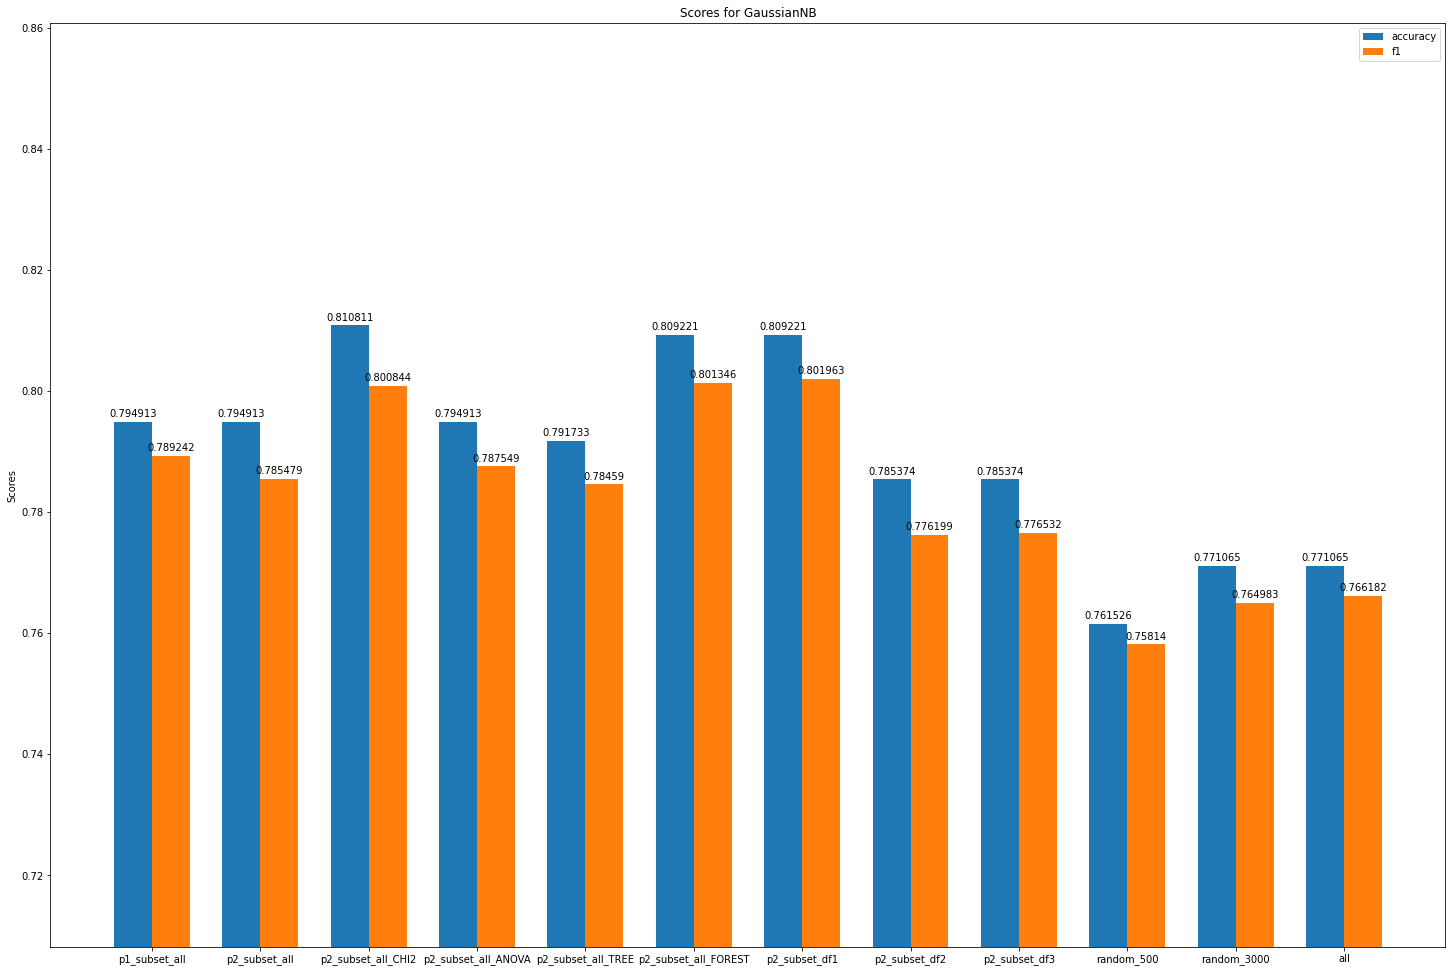

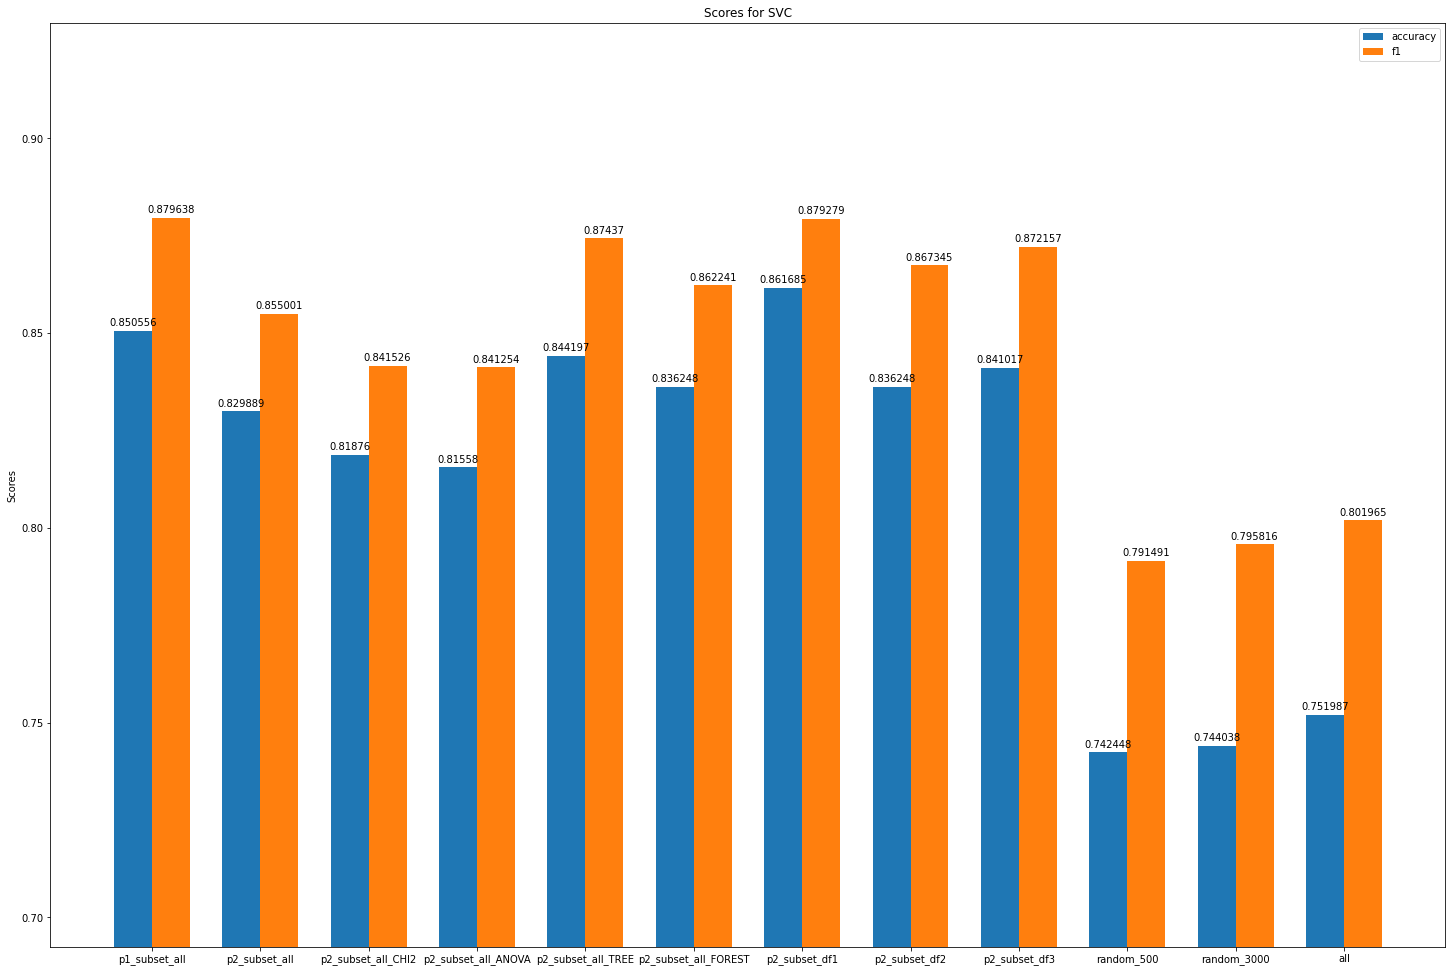

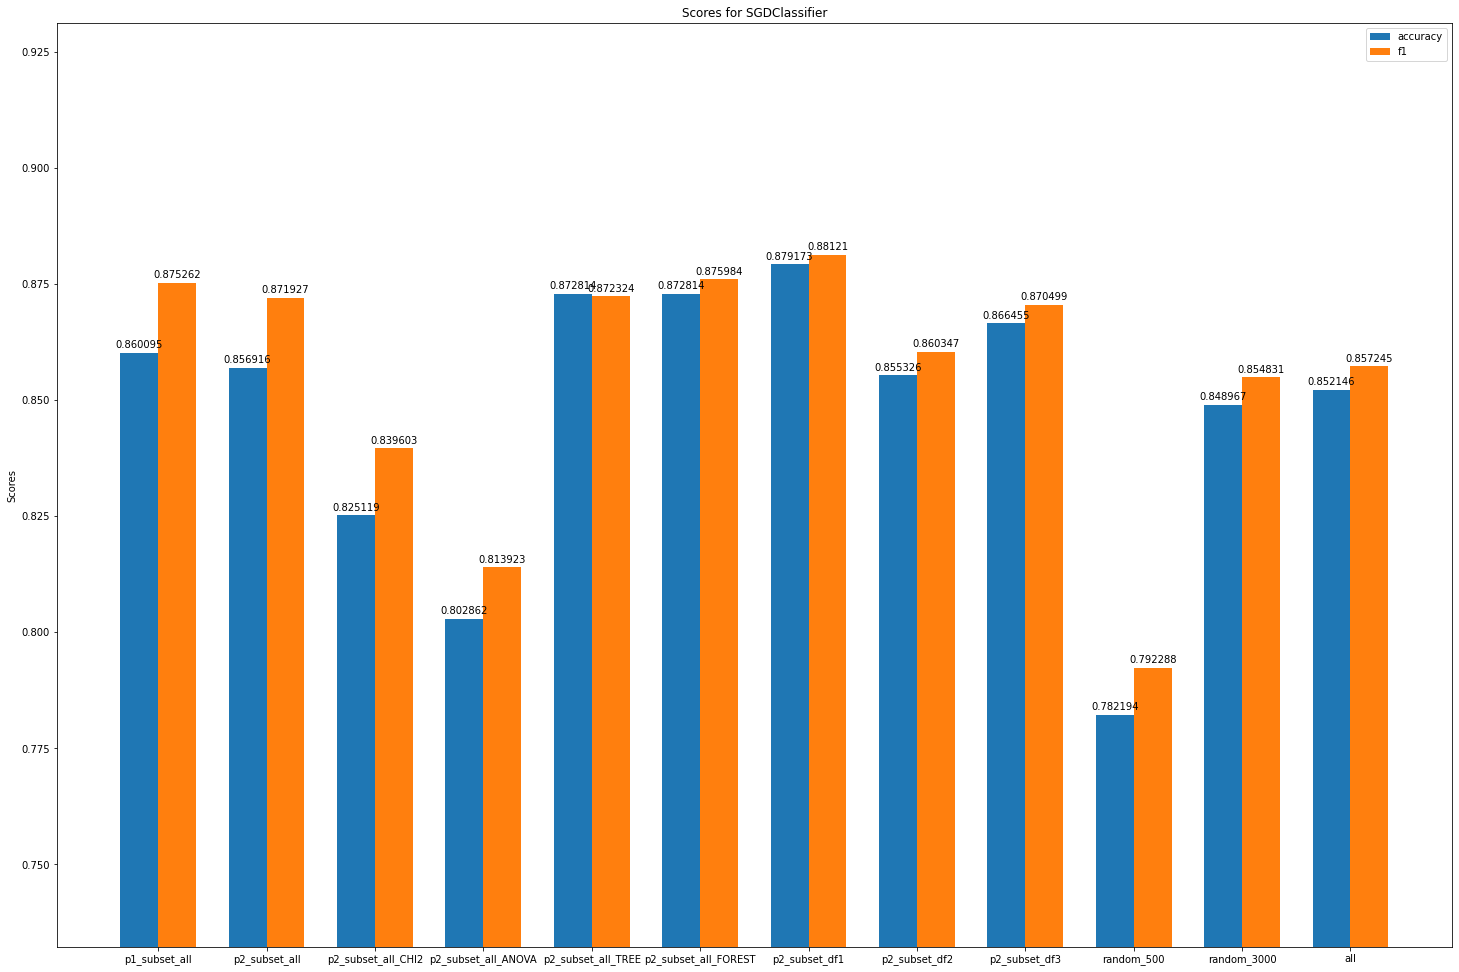

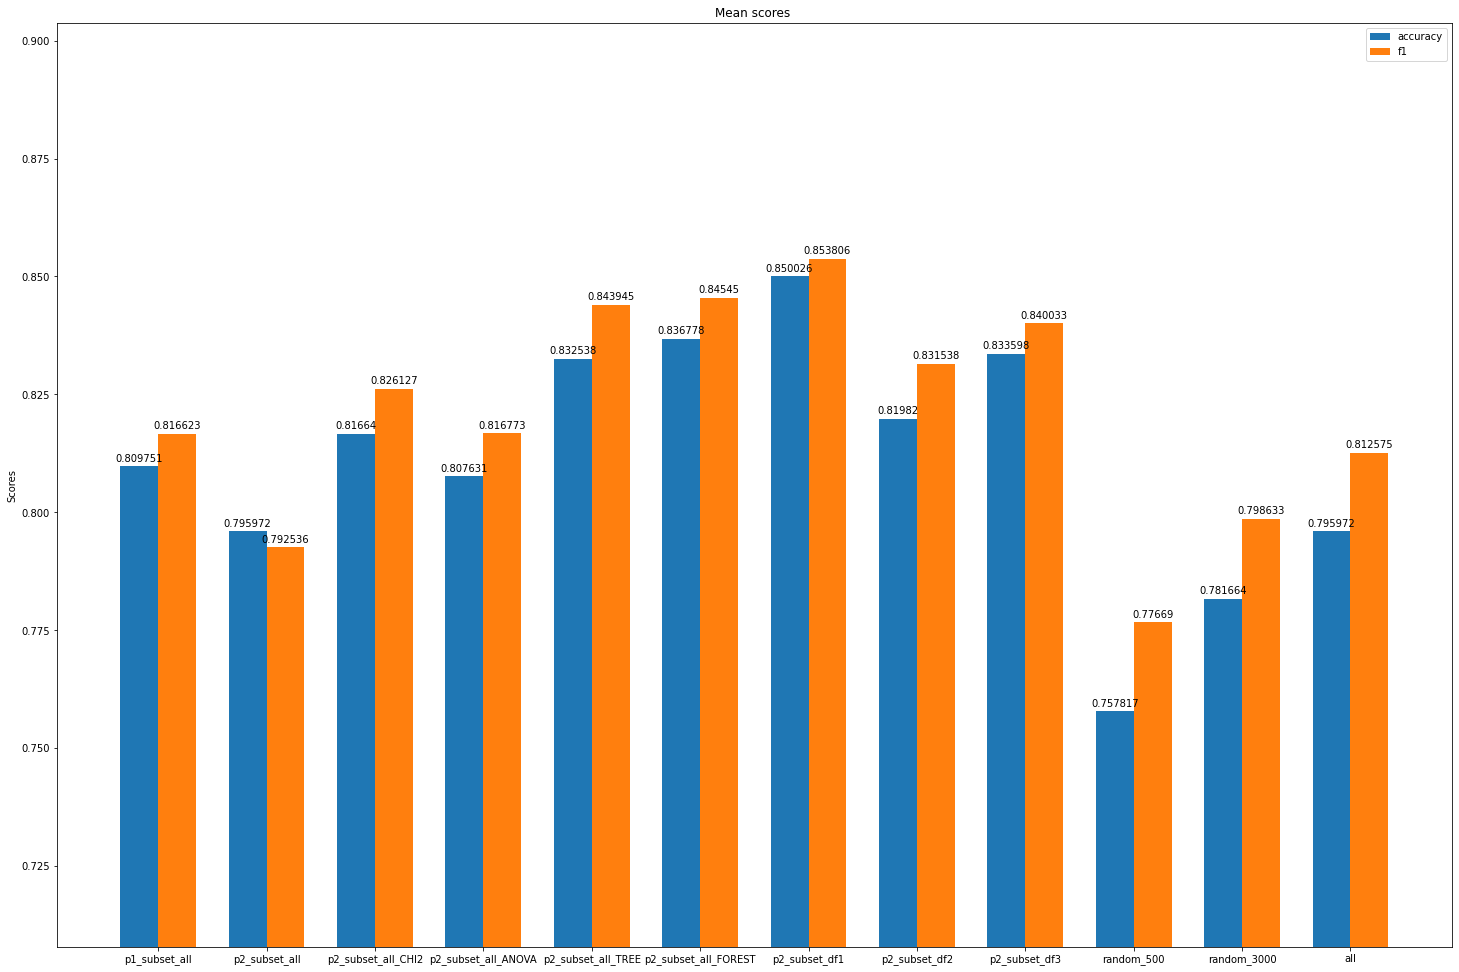

In [35]:
test_models_seperate(X_train1, y_train1, X_test1, y_test1, le1)
test_models_together(X_train1, y_train1, X_test1, y_test1, le1)

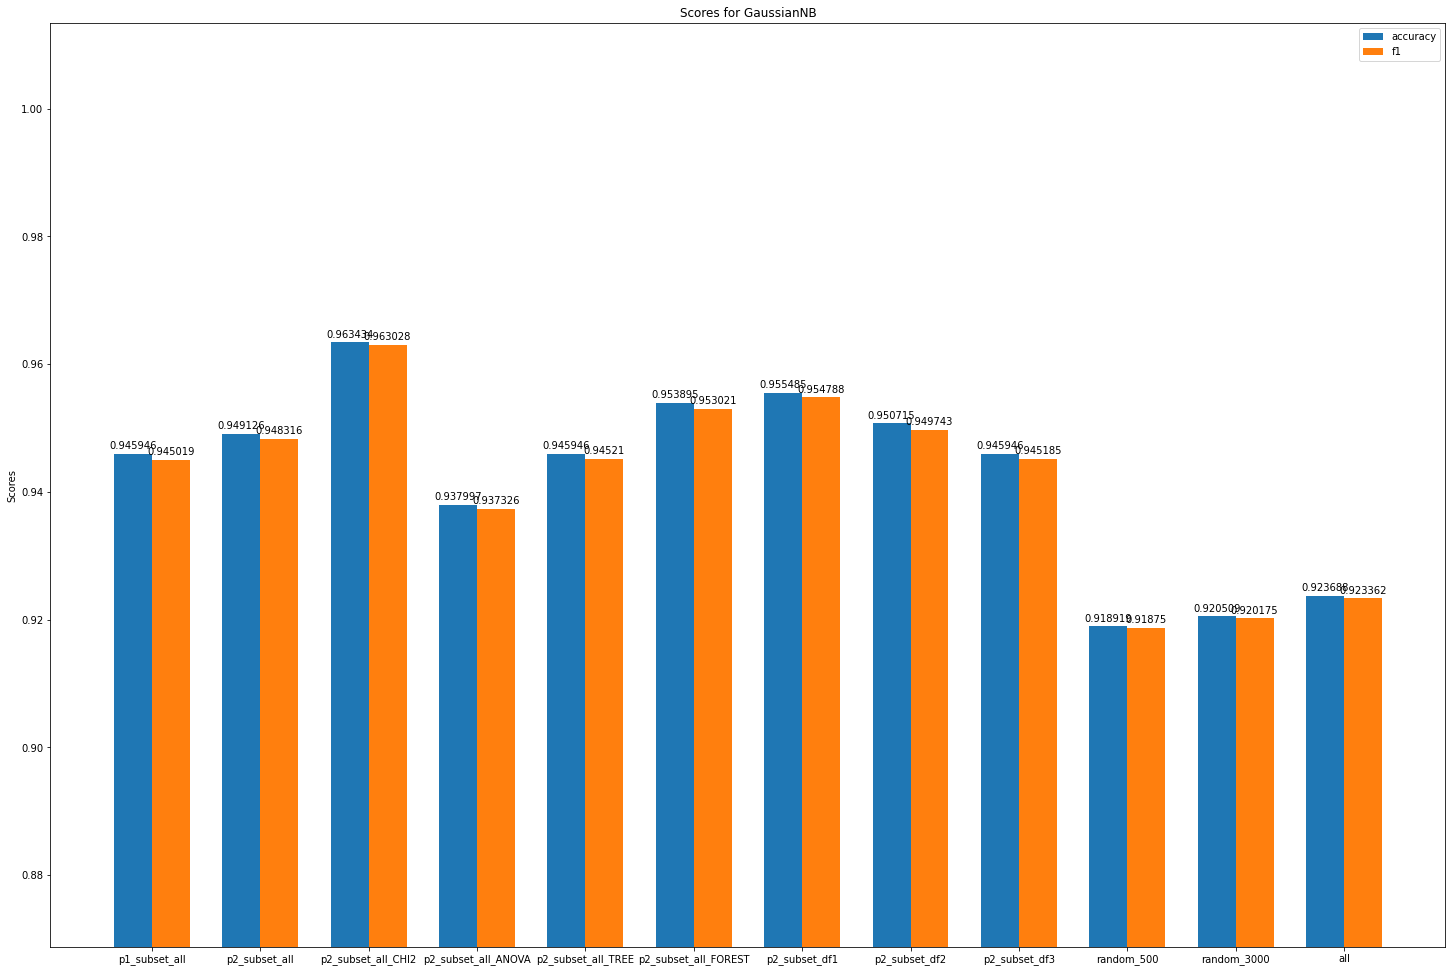

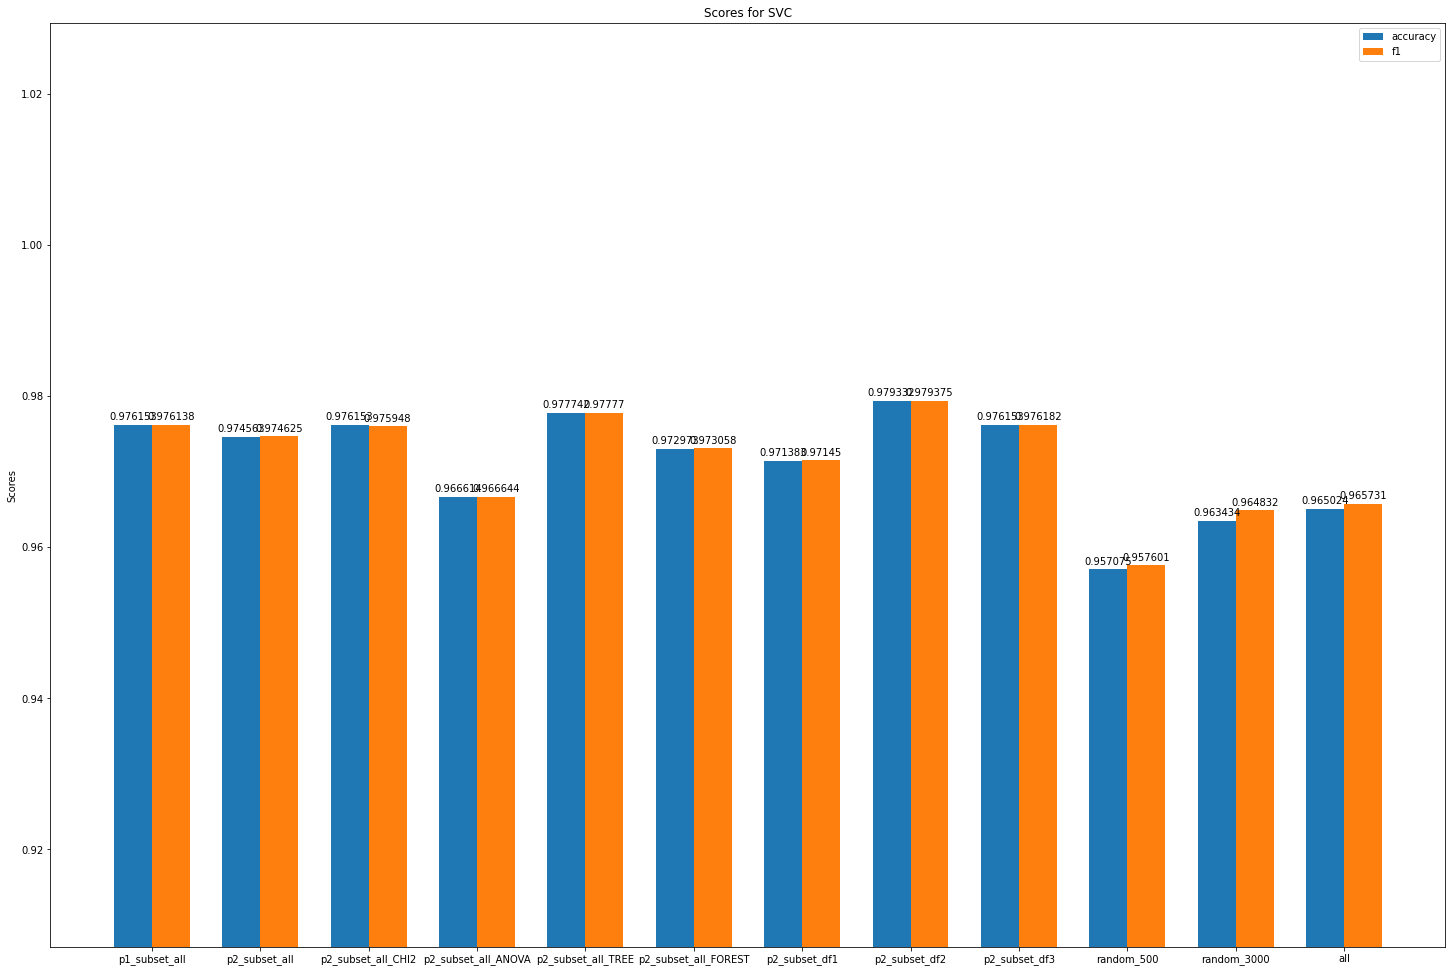

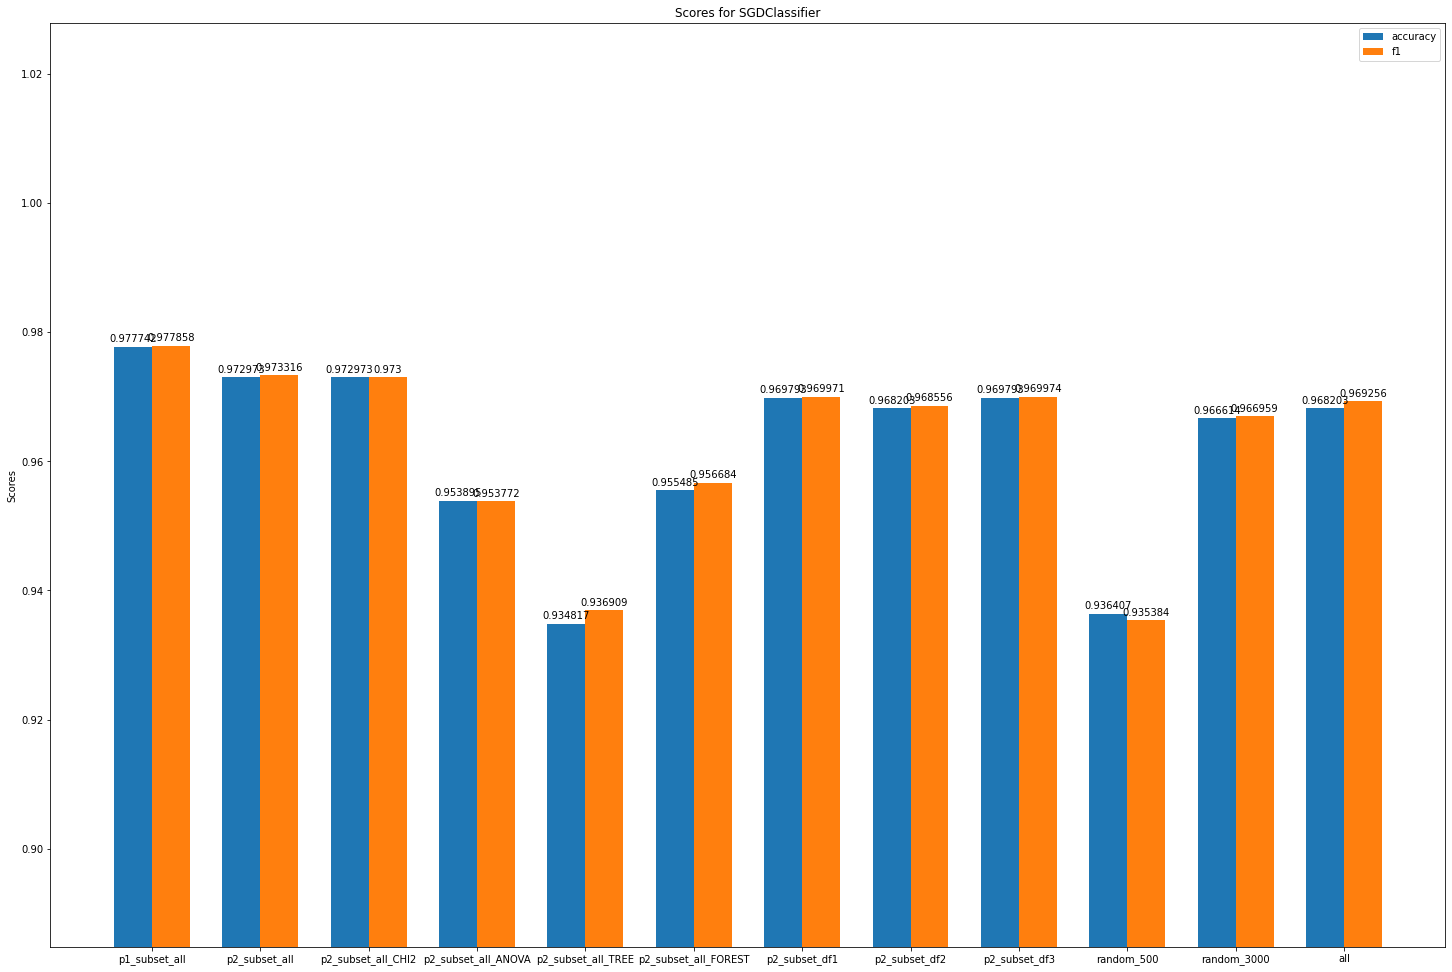

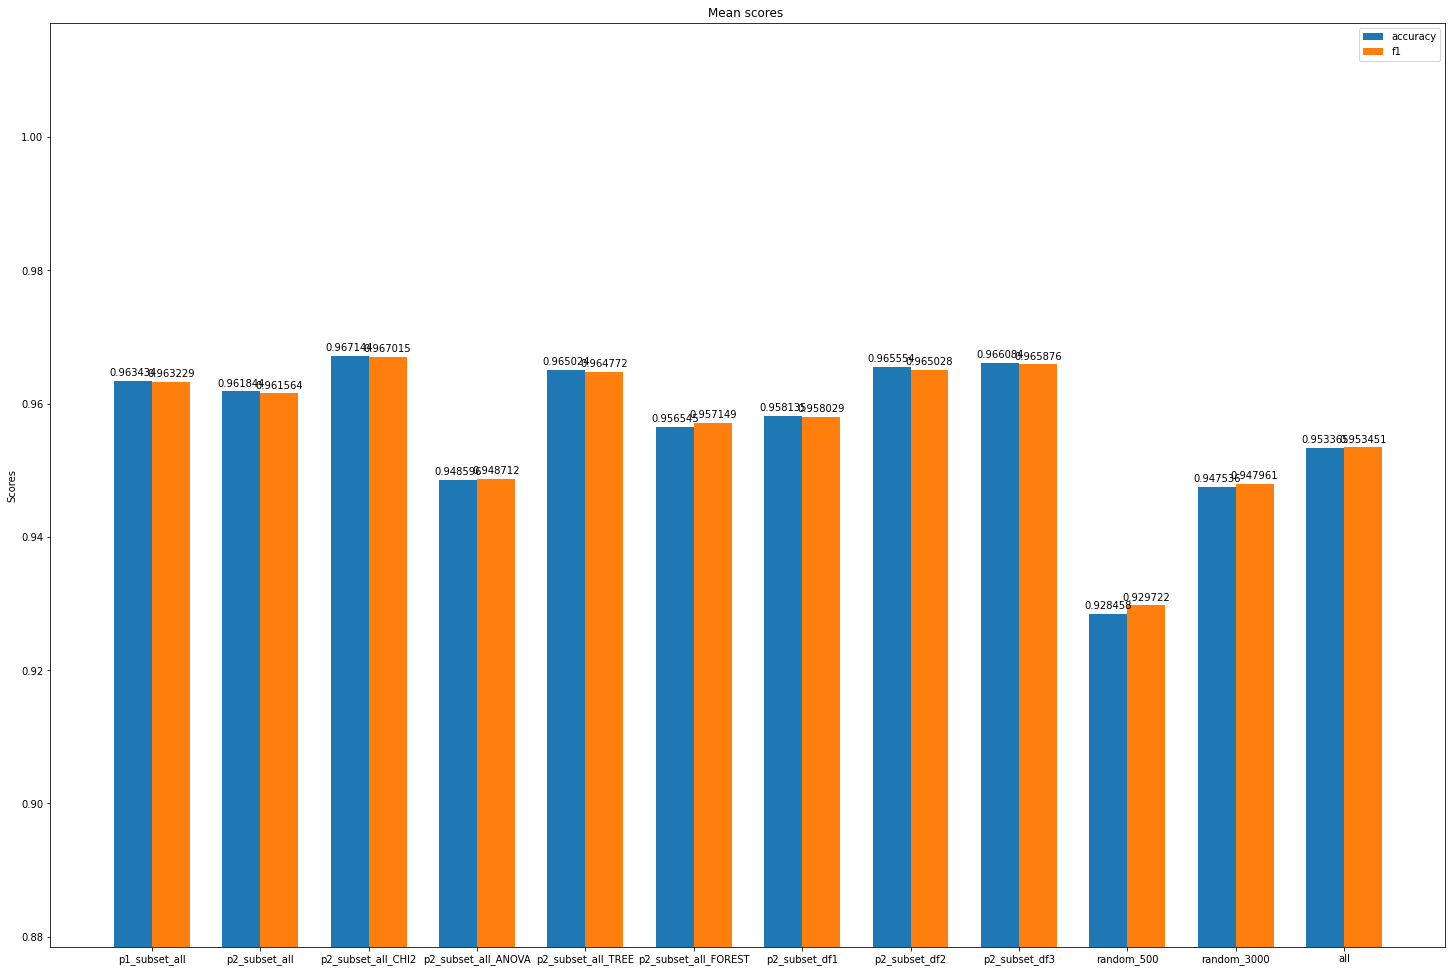

In [36]:
test_models_seperate(X_train2, y_train2, X_test2, y_test2, le2)
test_models_together(X_train2, y_train2, X_test2, y_test2, le2)

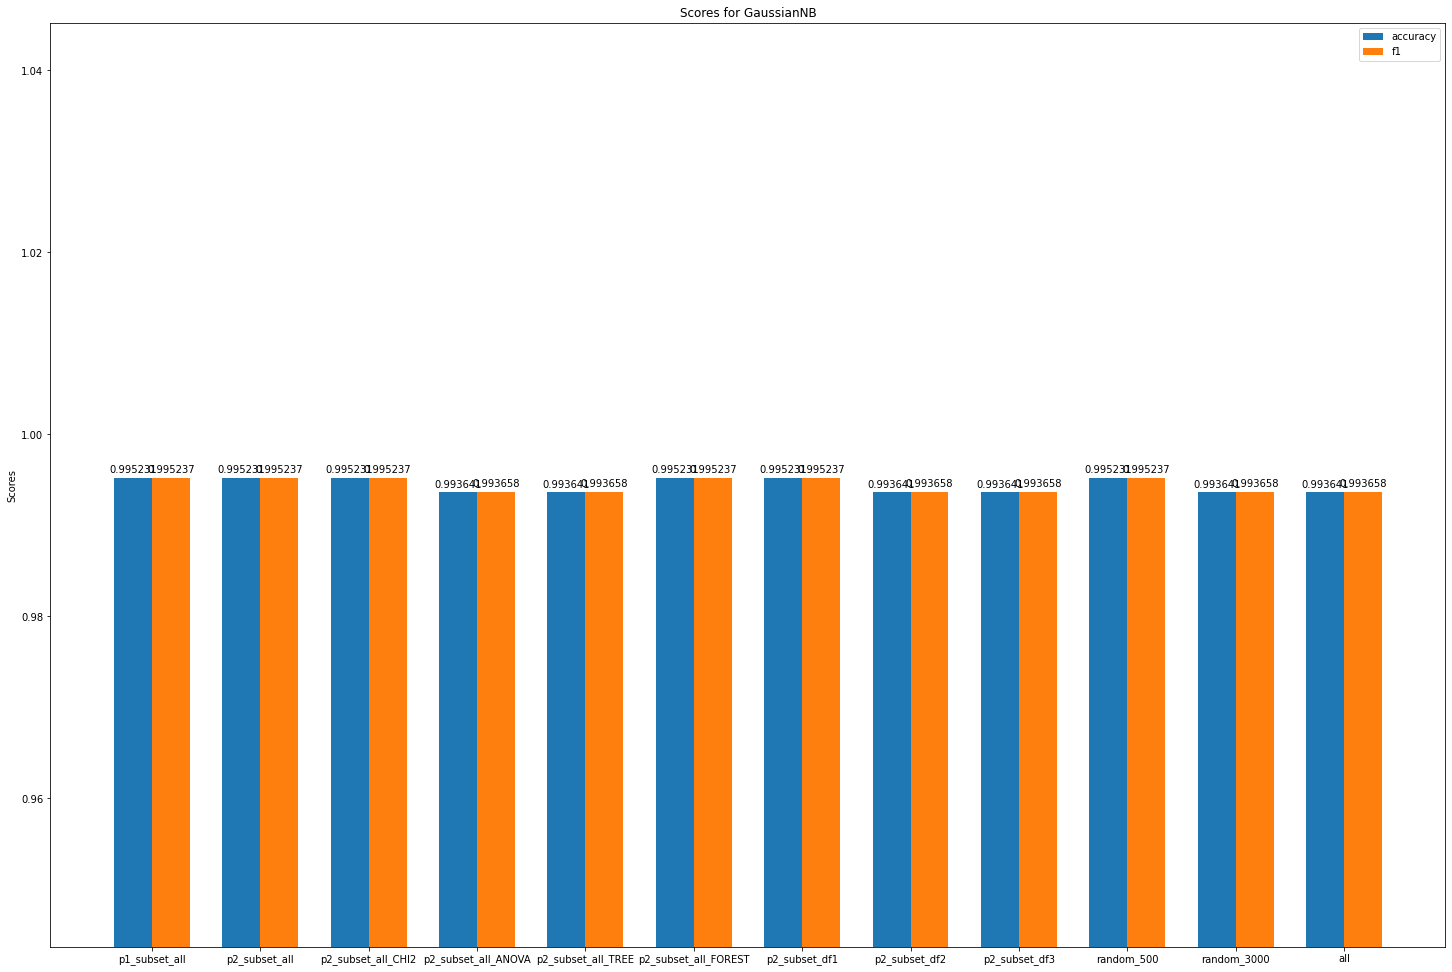

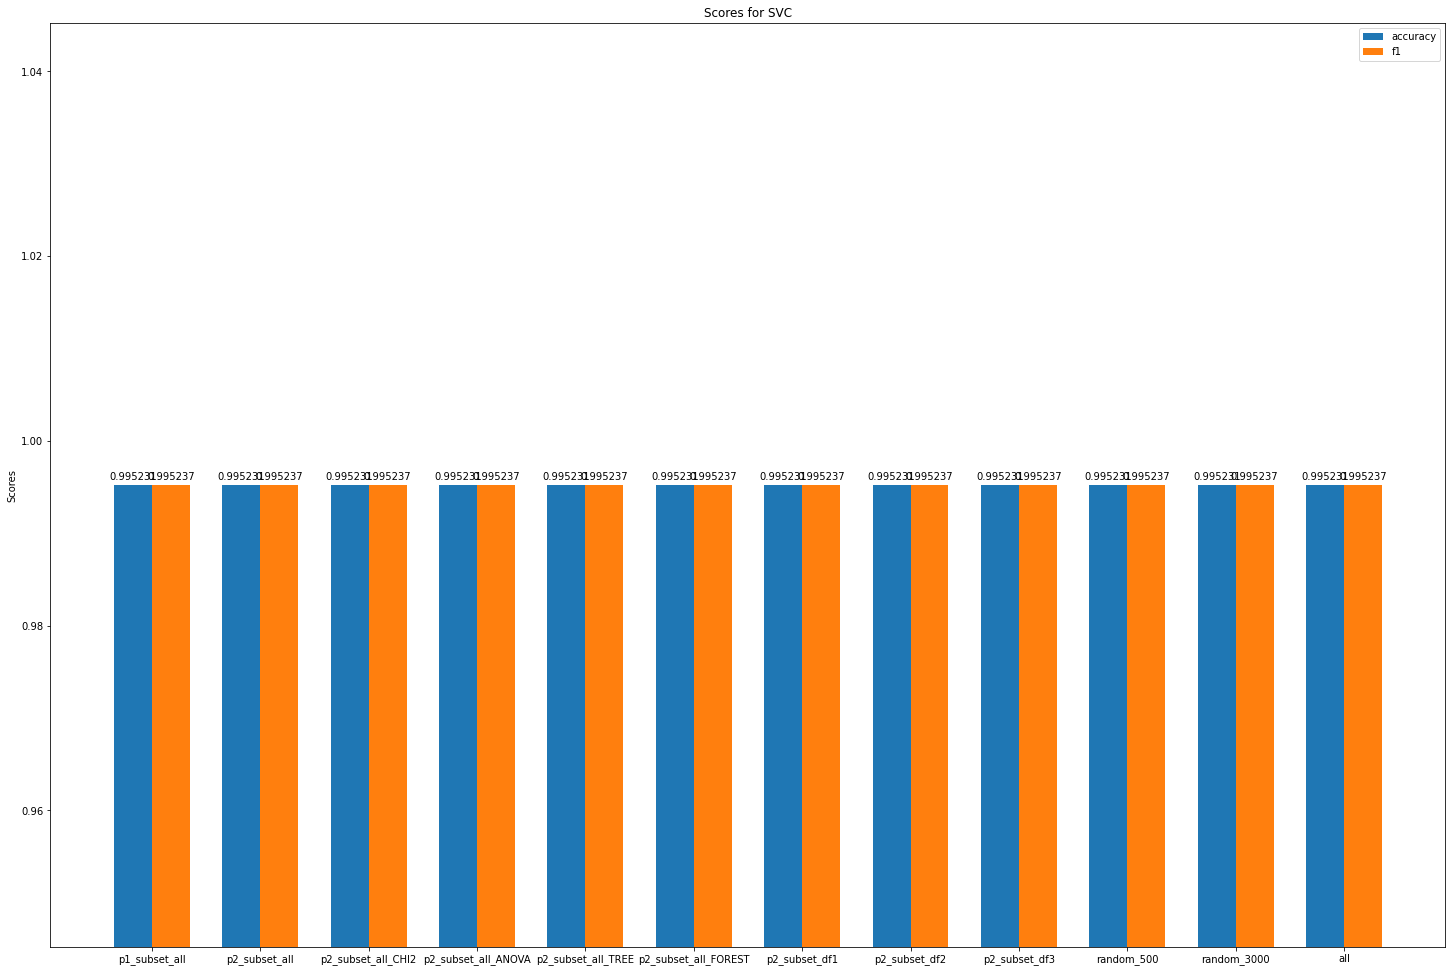

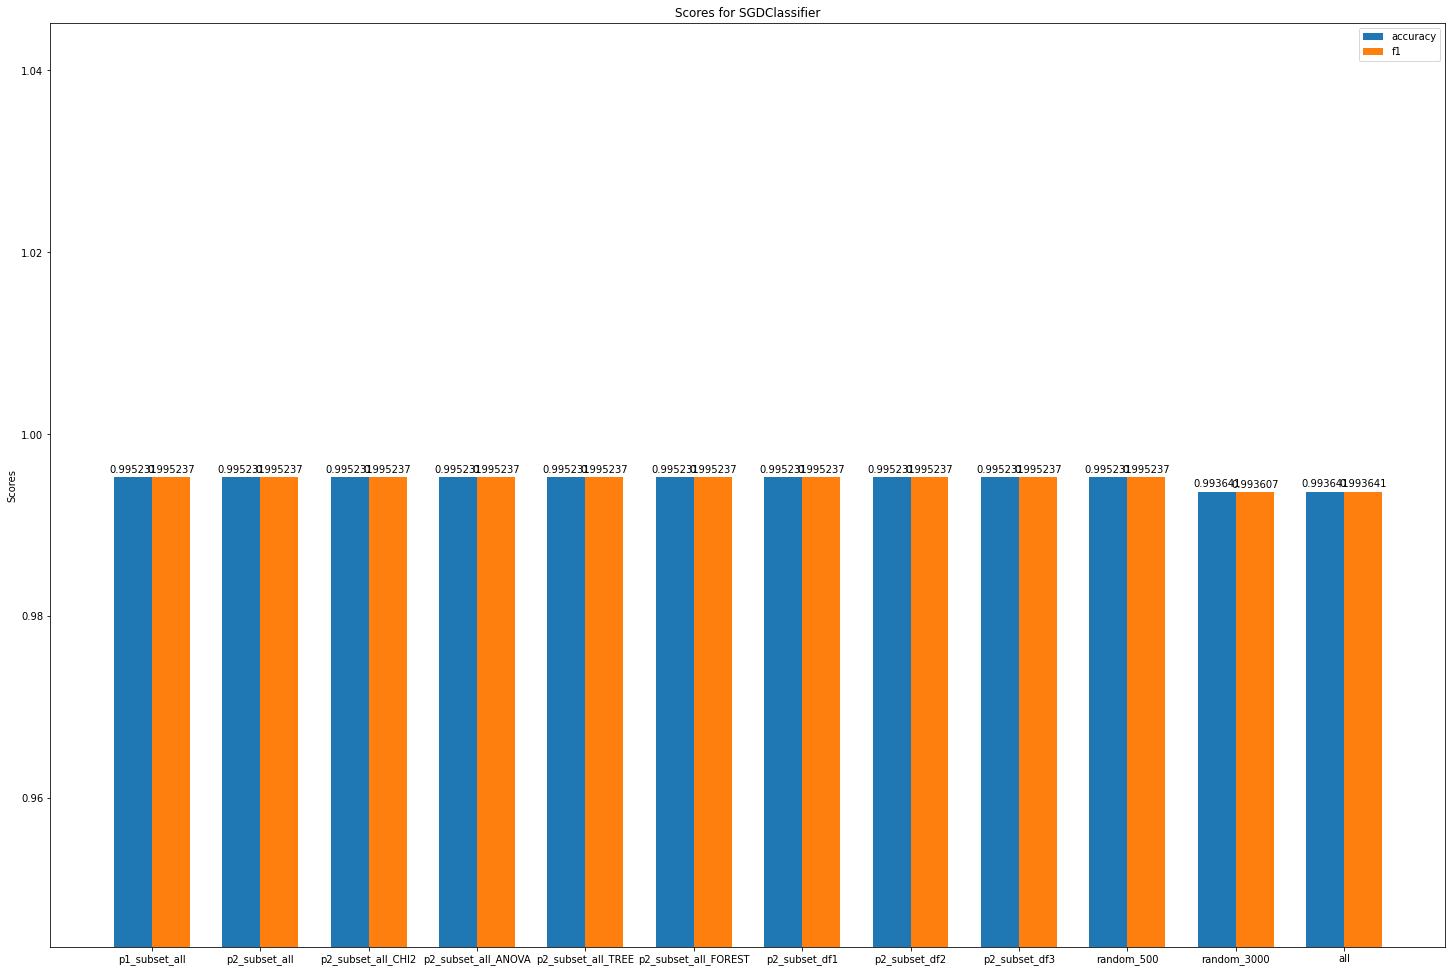

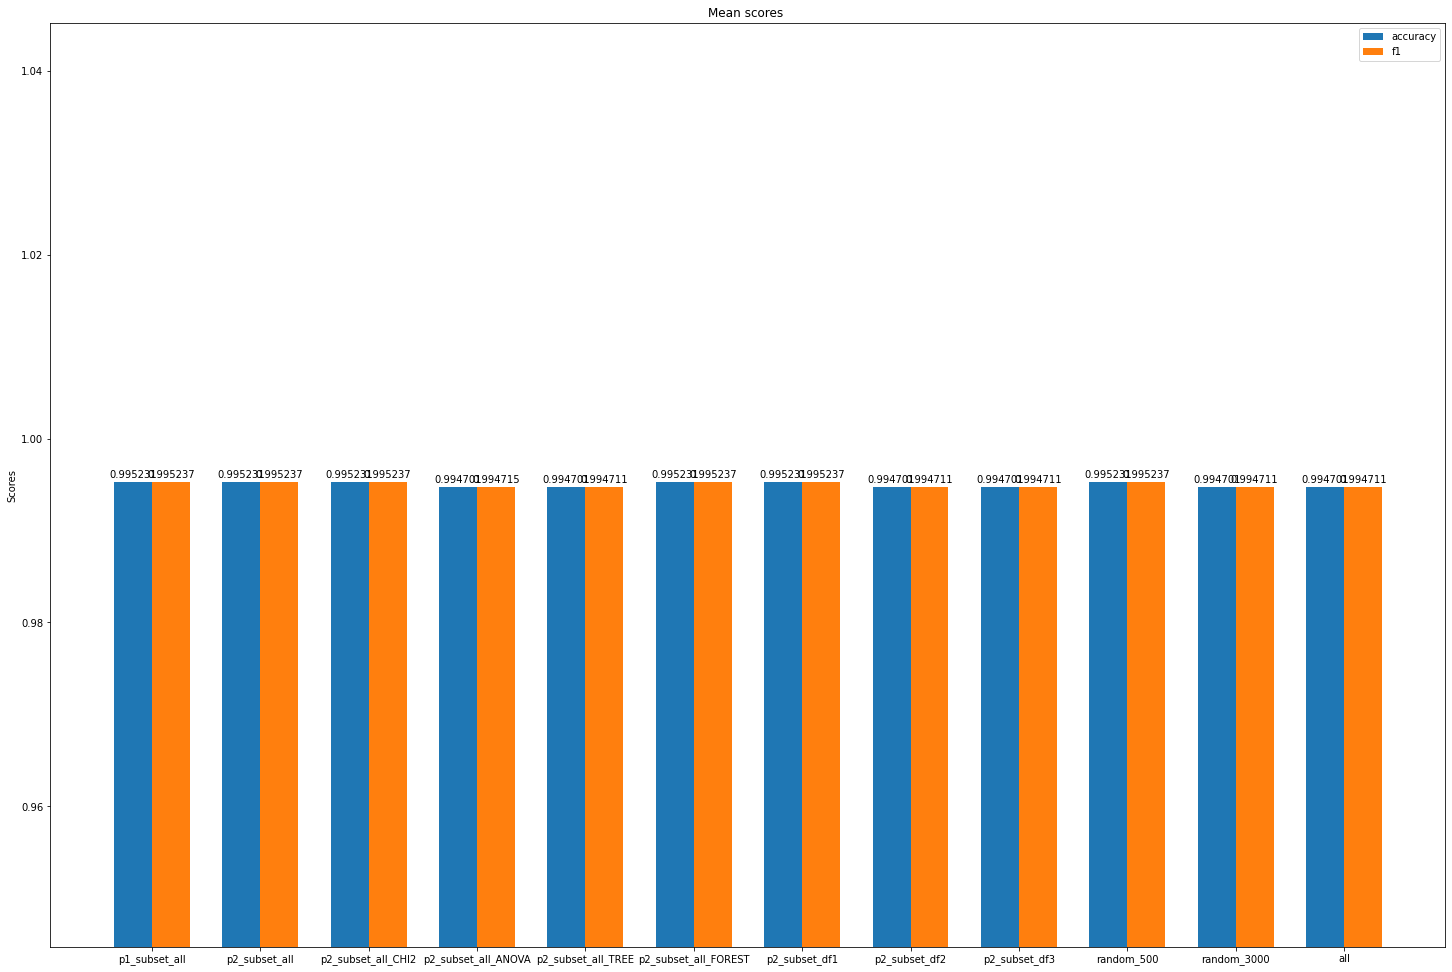

In [37]:
test_models_seperate(X_train3, y_train3, X_test3, y_test3, le3)
test_models_together(X_train3, y_train3, X_test3, y_test3, le3)

They are all pretty similar in results --> check with professor if the feature selection really did something ?